# COVID-19 Response effect assessment





In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats  as stats
import seaborn as sns; sns.set()
from datetime import datetime
import calendar
import os
from os import listdir
from os.path import isfile, join

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


## Pollution Data

Data collected from https://aqicn.org/

For each country, only one station from the most affected city (usually the capital) was considered.

*TODO: Get data from all stations in the city and take the averages*

Data from the 3 previous years were averaged to compute the daily baseline for pullution. Then, for co (industrial pollution) and no2 (fuel burning -- cars), the ratio between the 2020 data and the baseline was computed.

**co** is not used beuse few countries have these data

In [50]:
data_dir = 'data/'


df_orig_response = pd.read_csv(data_dir + 'pollution_countries.csv')

# df_orig_response = df_orig_response.rename(columns={'date':'Date'})

df_orig_response.sample(10)

Country       City        Date        co       no2        o3      pm10      pm25       so2
1250  United Kingdom     London  2020-04-11  0.764774  1.117518  1.512976  1.793478  1.646421  1.144095
1173  United Kingdom     London  2020-01-25  0.707416  0.954421  0.647059  1.673913  1.670282  1.036836
1292   United States  Manhattan  2020-01-29  0.521968  0.683306  1.779195       NaN  0.610619       NaN
1172  United Kingdom     London  2020-01-24  0.707416  1.431631  0.237889  1.195652  1.383948  0.715060
284            China      Wuhan  2020-02-22  0.937096  0.518116  1.730742  0.841106  0.858316  1.077063
628            Italy      Milan  2020-02-20  1.000000  1.019420  2.772050  0.423983  0.459799  1.568761
444           France      Paris  2020-04-06  1.000000  0.476132  2.340861  0.659121  0.750000  0.404082
652            Italy      Milan  2020-03-17  1.000000  0.826423  4.762887  0.688972  0.731156  1.148557
1316   United States  Manhattan  2020-02-22  0.985940  1.445923  1.004027       NaN  0.876106       NaN
121           Canada    Toronto  2020-01-05  0.877872  0.539536  1.188396       NaN  0.504113  0.696629

## COVID cases and other statistics

Total confirmed cases and total deaths data from ourworldindata.org. Other statistics were derived fom the base data.



In [51]:
df_orig_cases = pd.read_csv(data_dir + 'total_cases_countries_normalized.csv').rename(columns={'Name':'Country'})

df_orig_cases.sample(10)

Country        Date   Total  Day  TotalDeaths  TotalPer100k  TotalDeathsPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
4615          Ghana  2020-03-30   152.0   90          5.0      0.510631            0.016797      5.0    1.078014          1.000000      9.227121            1.000000    533.333333          400.000000
8771         Norway  2020-03-12   489.0   72          0.0      9.205718            0.000000      7.0    1.765343               NaN      1.219589                 NaN    773.214286                 NaN
1570         Bhutan  2020-04-20     5.0  111          0.0      0.662784            0.000000      NaN    1.000000               NaN      1.000000                 NaN      0.000000                 NaN
2155         Canada  2020-01-01     0.0    1          0.0      0.000000            0.000000      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
598           Aruba  2020-04-13    92.0  104          0.0     86.919552            0.000000     14.0    1.000000               NaN      1.000000                 NaN     43.750000                 NaN
11147        Sweden  2020-01-22     0.0   22          0.0      0.000000            0.000000      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
6656         Latvia  2020-03-22   124.0   82          0.0      6.434292            0.000000      4.0    1.117117               NaN      6.258588                 NaN    376.923077                 NaN
1943   Burkina Faso  2020-03-30   180.0   90          9.0      0.911322            0.045566      8.0    1.000000          1.000000      1.000000            1.000000    181.250000          200.000000
7993        Morocco  2020-03-23   115.0   83          4.0      0.319186            0.011102      4.0    1.197917          1.333333      3.838366            2.409421    310.714286          300.000000
6264          Japan  2020-04-04  2935.0   95         69.0      2.319624            0.054533     48.0    1.121513          1.095238      6.044247            7.619365     95.797198           40.816327

In [52]:
df_orig = pd.merge(df_orig_response, df_orig_cases, how='left')

df_orig.head()

Country       City        Date        co       no2        o3      pm10      pm25       so2  Total  Day  TotalDeaths  TotalPer100k  TotalDeathsPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
0  Brazil  São Paulo  2019-12-30  0.714617  0.759740  1.531188  1.317604  1.322886  1.238908    NaN  NaN          NaN           NaN                 NaN      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
1  Brazil  São Paulo  2019-12-31  0.944316  0.808442  1.350624  1.197822  1.274781  1.238908    0.0  0.0          0.0           0.0                 0.0      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
2  Brazil  São Paulo  2020-01-01  0.944316  0.720779  1.473408  1.197822  1.322886  1.238908    0.0  1.0          0.0           0.0                 0.0      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
3  Brazil  São Paulo  2020-01-02  1.174014  1.120130  1.032830  0.838475  0.913994  0.675768    0.0  2.0          0.0           0.0                 0.0      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
4  Brazil  São Paulo  2020-01-03  0.714617  0.623377  0.881156  0.419238  0.408892  0.675768    0.0  3.0          0.0           0.0                 0.0      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN

## Parameters



In [53]:
# After how many deaths to start assessing the response?
deaths_start = 7

# How many days to use, after the start of assessment, to measure the response
days_to_assess_response = 7

# How many days to use, after the start of assessment, to measure the response
days_to_assess_result = 18

df_response = df_orig[df_orig['TotalDeaths'] >= deaths_start]

df_response.head()

Country       City        Date        co       no2        o3      pm10      pm25       so2   Total   Day  TotalDeaths  TotalPer100k  TotalDeathsPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
82  Brazil  São Paulo  2020-03-21  0.714617  0.623377  1.263953  0.778584  0.913994  0.675768   904.0  81.0         11.0      0.431567            0.005251      9.0    1.455717          1.833333      1.845940            1.143551    822.448980                 NaN
83  Brazil  São Paulo  2020-03-22  0.484919  0.409091  1.206172  0.658802  0.721574  0.675768  1128.0  82.0         18.0      0.538504            0.008593     10.0    1.247788          1.636364      3.131141            1.407473    832.231405                 NaN
84  Brazil  São Paulo  2020-03-23  0.484919  0.584416  1.090611  0.718693  0.601312  1.238908  1546.0  83.0         25.0      0.738056            0.011935     11.0    1.370567          1.388889      2.198898            2.110011    673.000000                 NaN
85  Brazil  São Paulo  2020-03-24  0.484919  0.584416  1.003940  0.718693  0.601312  1.238908  1891.0  84.0         34.0      0.902757            0.016231     12.0    1.223157          1.360000      3.441049            2.254249    708.119658                 NaN
86  Brazil  São Paulo  2020-03-25  0.484919  0.672078  0.975049  0.838475  0.721574  1.238908  2201.0  85.0         46.0      1.050750            0.021960     13.0    1.163934          1.352941      4.566006            2.293057    656.357388              4500.0

## Measure the response

In this case, we use the average of the pollution to represent the amount of activity in the response period. The intensity of the response is the inverse of the activity (less activity -> stronger response).

We cannot use death statistics because few countries have enought data to measure the response.

In [54]:
df_response = df_response.sort_values(['Country', 'Date'])

df_activity_intensity = df_response.groupby('Country').head(days_to_assess_response)

df_activity_intensity = df_activity_intensity.groupby('Country')[['no2']].mean()

df_activity_intensity

no2
Country                 
Brazil          0.640074
Canada          0.584381
China           0.427019
France          0.611446
Germany         0.897610
Italy           0.835260
Netherlands     0.558271
Portugal        0.358196
Spain           0.781564
Sweden          0.857275
United Kingdom  0.724876
United States   0.874178

## Measure the situation at the begining of the response period

Here we are using Total (total confirmed cases) and Weekly Growth (in percentage).

In [55]:
df_response.groupby('Country').head()

Country       City        Date        co       no2        o3      pm10      pm25       so2   Total   Day  TotalDeaths  TotalPer100k  TotalDeathsPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
82            Brazil  São Paulo  2020-03-21  0.714617  0.623377  1.263953  0.778584  0.913994  0.675768   904.0  81.0         11.0      0.431567            0.005251      9.0    1.455717          1.833333      1.845940            1.143551    822.448980                 NaN
83            Brazil  São Paulo  2020-03-22  0.484919  0.409091  1.206172  0.658802  0.721574  0.675768  1128.0  82.0         18.0      0.538504            0.008593     10.0    1.247788          1.636364      3.131141            1.407473    832.231405                 NaN
84            Brazil  São Paulo  2020-03-23  0.484919  0.584416  1.090611  0.718693  0.601312  1.238908  1546.0  83.0         25.0      0.738056            0.011935     11.0    1.370567          1.388889      2.198898            2.110011    673.000000                 NaN
85            Brazil  São Paulo  2020-03-24  0.484919  0.584416  1.003940  0.718693  0.601312  1.238908  1891.0  84.0         34.0      0.902757            0.016231     12.0    1.223157          1.360000      3.441049            2.254249    708.119658                 NaN
86            Brazil  São Paulo  2020-03-25  0.484919  0.672078  0.975049  0.838475  0.721574  1.238908  2201.0  85.0         46.0      1.050750            0.021960     13.0    1.163934          1.352941      4.566006            2.293057    656.357388         4500.000000
194           Canada    Toronto  2020-03-18  0.917775  0.853448  1.452484       NaN  0.814336  1.044944   569.0  78.0          8.0      1.535441            0.021588     11.0    1.341981          2.000000      2.356465            1.000000    511.827957          700.000000
195           Canada    Toronto  2020-03-19  1.037485  0.725922  1.188396       NaN  1.473561  1.741573   690.0  79.0          9.0      1.861958            0.024286     12.0    1.212654          1.125000      3.594954            5.884949    569.902913          800.000000
196           Canada    Toronto  2020-03-20  0.997582  0.441439  1.100367       NaN  0.814336  0.696629   846.0  80.0         10.0      2.282922            0.026985     13.0    1.226087          1.111111      3.400651            6.578813    513.043478          900.000000
197           Canada    Toronto  2020-03-21  0.758162  0.255054  1.496499       NaN  0.504113  0.696629   971.0  81.0         12.0      2.620234            0.032382     14.0    1.147754          1.200000      5.029836            3.801784    451.704545         1100.000000
198           Canada    Toronto  2020-03-22  0.718259  0.461058  1.408469       NaN  0.659224  0.696629  1302.0  82.0         18.0      3.513434            0.048573     15.0    1.340886          1.500000      2.363026            1.709511    433.606557         1700.000000
253            China      Wuhan  2020-01-22  1.091301  0.790459  1.228518  1.234816  1.234771  0.927471   526.0  22.0         17.0      0.037768            0.001221     17.0    1.362694          2.833333      2.239833            0.665557    791.525424          750.000000
254            China      Wuhan  2020-01-23  1.281093  0.637681  1.135800  1.234816  1.234771  0.927471   623.0  23.0         17.0      0.044732            0.001221     18.0    1.184411          1.000000      4.095518            1.000000    955.932203          750.000000
255            China      Wuhan  2020-01-24  0.533789  0.365338  1.607118  0.608460  0.670089  0.927471   882.0  24.0         26.0      0.063329            0.001867     19.0    1.415730          1.529412      1.993833            1.631383   1300.000000         1200.000000
256            China      Wuhan  2020-01-25  0.818476  0.305556  1.576212  0.644252  0.805613  0.777879  1323.0  25.0         41.0      0.094993            0.002944     20.0    1.500000          1.576923  

In [56]:
# assess_variables = ['Total', 'WeeklyGrowth']

assess_variables = ['Total', 'TotalDeaths', 'WeeklyGrowth', 'WeeklyGrowthDeaths']

assess_variables_exp = ['Total', 'TotalDeaths']

df_situation_start = df_response.groupby('Country').head(1).set_index('Country')[assess_variables]

df_situation_start

Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                              
Brazil           904.0         11.0    822.448980                 NaN
Canada           569.0          8.0    511.827957               700.0
China            526.0         17.0    791.525424               750.0
France           423.0          7.0   1013.157895               250.0
Germany         3795.0          8.0    348.051948                 NaN
Italy            322.0         11.0  10633.333333                 NaN
Netherlands      959.0         12.0    410.106383              1100.0
Portugal        1280.0         12.0    657.396450                 NaN
Spain           1204.0         28.0    956.140351                 NaN
Sweden          1121.0          7.0    352.016129                 NaN
United Kingdom   590.0         10.0    413.043478               900.0
United States    125.0          9.0    135.849057                 NaN

## Measure the situation after the response period

Same variables as before

In [57]:
df_response = df_response.sort_values(['Country', 'Date'])

df_situation_final = df_response.groupby('Country').head(days_to_assess_result)

# only keep countries that have results beyond the number of days to assess result
valid_countries = df_situation_final.groupby('Country').count().iloc[:, 0] == days_to_assess_result

df_situation_final = df_situation_final.groupby('Country').tail(1).set_index('Country')[assess_variables]

df_situation_final = df_situation_final[valid_countries]

df_situation_final

Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                               
Brazil          12056.0        553.0    163.288928          247.798742
Canada          12519.0        187.0    167.786096          252.830189
China           34625.0        723.0    193.208570          179.150579
France          16018.0        674.0    195.371566          430.708661
Germany         67366.0        732.0    113.494327          391.275168
Italy           23980.0       1811.0    225.152542          394.808743
Netherlands     12595.0       1039.0    126.528777          276.449275
Portugal        12442.0        345.0     67.163778          115.625000
Spain           56188.0       4089.0    227.684143          433.116037
Sweden           5466.0        282.0     94.796864          327.272727
United Kingdom  19522.0       1228.0    243.515749          337.010676
United States   19624.0        260.0    802.667893          453.191489

## Measure the effect

Efect is the ratio of the situation at the begining and the situation at the end.

In [58]:
df_situation_final

Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                               
Brazil          12056.0        553.0    163.288928          247.798742
Canada          12519.0        187.0    167.786096          252.830189
China           34625.0        723.0    193.208570          179.150579
France          16018.0        674.0    195.371566          430.708661
Germany         67366.0        732.0    113.494327          391.275168
Italy           23980.0       1811.0    225.152542          394.808743
Netherlands     12595.0       1039.0    126.528777          276.449275
Portugal        12442.0        345.0     67.163778          115.625000
Spain           56188.0       4089.0    227.684143          433.116037
Sweden           5466.0        282.0     94.796864          327.272727
United Kingdom  19522.0       1228.0    243.515749          337.010676
United States   19624.0        260.0    802.667893          453.191489

In [59]:
df_effect = df_situation_final / df_situation_start

df_effect.columns = [s + '_ratio' for s in df_effect.columns]

df_effect

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio
Country                                                                                     
Brazil            13.336283          50.272727            0.198540                       NaN
Canada            22.001757          23.375000            0.327817                  0.361186
China             65.826996          42.529412            0.244096                  0.238867
France            37.867612          96.285714            0.192834                  1.722835
Germany           17.751252          91.500000            0.326084                       NaN
Italy             74.472050         164.636364            0.021174                       NaN
Netherlands       13.133472          86.583333            0.308527                  0.251318
Portugal           9.720313          28.750000            0.102166                       NaN
Spain             46.667774         146.035714            0.238128                       NaN
Sweden             4.876004          40.285714            0.269297                       NaN
United Kingdom    33.088136         122.800000            0.589564                  0.374456
United States    156.992000          28.888889            5.908528                       NaN

In [60]:
df_effect_join = df_situation_start.join(df_situation_final, rsuffix='2')

for var in assess_variables_exp:
    df_effect[var + '_rate'] = df_effect_join.apply(lambda x: math.pow((x[var + '2']/x[var]), (1.0/days_to_assess_result)), axis=1)
    
df_effect

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate
Country                                                                                                                   
Brazil            13.336283          50.272727            0.198540                       NaN    1.154787          1.243136
Canada            22.001757          23.375000            0.327817                  0.361186    1.187356          1.191357
China             65.826996          42.529412            0.244096                  0.238867    1.261893          1.231637
France            37.867612          96.285714            0.192834                  1.722835    1.223719          1.288837
Germany           17.751252          91.500000            0.326084                       NaN    1.173280          1.285191
Italy             74.472050         164.636364            0.021174                       NaN    1.270573          1.327823
Netherlands       13.133472          86.583333            0.308527                  0.251318    1.153804          1.281254
Portugal           9.720313          28.750000            0.102166                       NaN    1.134674          1.205134
Spain             46.667774         146.035714            0.238128                       NaN    1.238007          1.319009
Sweden             4.876004          40.285714            0.269297                       NaN    1.092008          1.227934
United Kingdom    33.088136         122.800000            0.589564                  0.374456    1.214580          1.306371
United States    156.992000          28.888889            5.908528                       NaN    1.324321          1.205457

In [61]:
df_effect = df_effect.join(df_situation_final)

df_effect

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate    Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths
Country                                                                                                                                                                           
Brazil            13.336283          50.272727            0.198540                       NaN    1.154787          1.243136  12056.0        553.0    163.288928          247.798742
Canada            22.001757          23.375000            0.327817                  0.361186    1.187356          1.191357  12519.0        187.0    167.786096          252.830189
China             65.826996          42.529412            0.244096                  0.238867    1.261893          1.231637  34625.0        723.0    193.208570          179.150579
France            37.867612          96.285714            0.192834                  1.722835    1.223719          1.288837  16018.0        674.0    195.371566          430.708661
Germany           17.751252          91.500000            0.326084                       NaN    1.173280          1.285191  67366.0        732.0    113.494327          391.275168
Italy             74.472050         164.636364            0.021174                       NaN    1.270573          1.327823  23980.0       1811.0    225.152542          394.808743
Netherlands       13.133472          86.583333            0.308527                  0.251318    1.153804          1.281254  12595.0       1039.0    126.528777          276.449275
Portugal           9.720313          28.750000            0.102166                       NaN    1.134674          1.205134  12442.0        345.0     67.163778          115.625000
Spain             46.667774         146.035714            0.238128                       NaN    1.238007          1.319009  56188.0       4089.0    227.684143          433.116037
Sweden             4.876004          40.285714            0.269297                       NaN    1.092008          1.227934   5466.0        282.0     94.796864          327.272727
United Kingdom    33.088136         122.800000            0.589564                  0.374456    1.214580          1.306371  19522.0       1228.0    243.515749          337.010676
United States    156.992000          28.888889            5.908528                       NaN    1.324321          1.205457  19624.0        260.0    802.667893          453.191489

In [62]:
# effect_var = ['Total_ratio',
#               'Increase in confirmed cases (%)**',
#               '** Increase in confirmed cases in the country after\n {days_to_assess_result} days counting from first day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)]

effect_var = ['WeeklyGrowthDeaths',
              'Weekly growth rate of deaths (%)**',
              '** Weekly growth rate of deaths in the\n country after {days_to_assess_result} days counting from first\n day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)] 

# effect_var = ['WeeklyGrowthDeaths_ratio',
#               'Weekly growth rate of deaths (%)**',
#               '** Weekly growth rate of deaths in the\n country after {days_to_assess_result} days counting from first\n day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)] 

# effect_var = ['TotalDeaths',
#               'Total deaths**',
#               '** Total number of deaths in the country\n in the {days_to_assess_result} days counting from first\n day after {deaths_start}th death.'.format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result)] 


df_effect_final = df_effect.join(df_activity_intensity)

df_effect_final = df_effect_final[~df_effect_final[effect_var[0]].isna()].sort_values(effect_var[0])

df_effect_final

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate    Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths       no2
Country                                                                                                                                                                                     
Portugal           9.720313          28.750000            0.102166                       NaN    1.134674          1.205134  12442.0        345.0     67.163778          115.625000  0.358196
China             65.826996          42.529412            0.244096                  0.238867    1.261893          1.231637  34625.0        723.0    193.208570          179.150579  0.427019
Brazil            13.336283          50.272727            0.198540                       NaN    1.154787          1.243136  12056.0        553.0    163.288928          247.798742  0.640074
Canada            22.001757          23.375000            0.327817                  0.361186    1.187356          1.191357  12519.0        187.0    167.786096          252.830189  0.584381
Netherlands       13.133472          86.583333            0.308527                  0.251318    1.153804          1.281254  12595.0       1039.0    126.528777          276.449275  0.558271
Sweden             4.876004          40.285714            0.269297                       NaN    1.092008          1.227934   5466.0        282.0     94.796864          327.272727  0.857275
United Kingdom    33.088136         122.800000            0.589564                  0.374456    1.214580          1.306371  19522.0       1228.0    243.515749          337.010676  0.724876
Germany           17.751252          91.500000            0.326084                       NaN    1.173280          1.285191  67366.0        732.0    113.494327          391.275168  0.897610
Italy             74.472050         164.636364            0.021174                       NaN    1.270573          1.327823  23980.0       1811.0    225.152542          394.808743  0.835260
France            37.867612          96.285714            0.192834                  1.722835    1.223719          1.288837  16018.0        674.0    195.371566          430.708661  0.611446
Spain             46.667774         146.035714            0.238128                       NaN    1.238007          1.319009  56188.0       4089.0    227.684143          433.116037  0.781564
United States    156.992000          28.888889            5.908528                       NaN    1.324321          1.205457  19624.0        260.0    802.667893          453.191489  0.874178

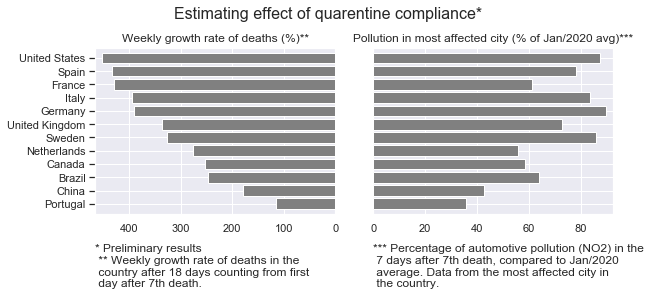

In [63]:
# df_effect_display = df_effect_final.drop('China')

df_effect_display = df_effect_final

y = np.arange(len(df_effect_display))

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 4), constrained_layout=True)

fig.suptitle('Estimating effect of quarentine compliance*', fontsize=16)

# axes[0].barh(y, (df_effect_display.Total - 1) * 100, align='center', color='gray', zorder=10)
axes[0].barh(y, df_effect_display[effect_var[0]], align='center', color='gray', zorder=10)
axes[0].set(title=effect_var[1])
axes[1].barh(y, df_effect_display.no2 * 100, align='center', color='gray', zorder=10)
axes[1].set(title='Pollution in most affected city (% of Jan/2020 avg)***')

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=df_effect_display.index)
axes[0].yaxis.tick_left()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

# fig.tight_layout()
# fig.subplots_adjust(wspace=0.05)

annotation = "* Preliminary results\n " + effect_var[2]

annotation2 = """*** Percentage of automotive pollution (NO2) in the\n {days_to_assess_response} days after {deaths_start}th death, compared to Jan/2020\n average. Data from the most affected city in\n the country.""".format(deaths_start=deaths_start, days_to_assess_response = days_to_assess_response, days_to_assess_result = days_to_assess_result) 


axes[0].annotate(annotation, (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top')
axes[1].annotate(annotation2, (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top')


plt.show()


## Analysis

Correlations and p-values for the effect and response variables.

Effect variables: 

* Weekly Growth (how much weekly growth of cases has increased)
* Total (how much total number of cases has increased)

Response variable:

* no2 (how much polution was measured in comparison with the historic average (3 years)

In [64]:
from scipy.stats import pearsonr

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

display(df_effect_final.corr(method='pearson'))

display(df_effect_final.corr(method=pearsonr_pval))

print(df_effect_final.corr(method=pearsonr_pval)['no2'].idxmin())

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate     Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths       no2
Total_ratio                  1.000000           0.019979            0.838870                  0.063009    0.898543         -0.063250  0.098878     0.060234      0.930889            0.467482  0.319748
TotalDeaths_ratio            0.019979           1.000000           -0.310887                  0.320360    0.284857          0.974679  0.430790     0.767371     -0.113661            0.547684  0.397306
WeeklyGrowth_ratio           0.838870          -0.310887            1.000000                 -0.444320    0.575464         -0.350950 -0.071686    -0.218235      0.958791            0.396512  0.355183
WeeklyGrowthDeaths_ratio     0.063009           0.320360           -0.444320                  1.000000    0.199309          0.341644 -0.228115    -0.146761      0.183700            0.836688  0.236510
Total_rate                   0.898543           0.284857            0.575464                  0.199309    1.000000          0.200375  0.281359     0.278518      0.757418            0.477873  0.209821
TotalDeaths_rate            -0.063250           0.974679           -0.350950                  0.341644    0.200375          1.000000  0.446462     0.711320     -0.174503            0.535202  0.377380
Total                        0.098878           0.430790           -0.071686                 -0.228115    0.281359          0.446462  1.000000     0.549392     -0.016780            0.356507  0.344191
TotalDeaths                  0.060234           0.767371           -0.218235                 -0.146761    0.278518          0.711320  0.549392     1.000000     -0.043680            0.401385  0.242286
WeeklyGrowth                 0.930889          -0.113661            0.958791                  0.183700    0.757418         -0.174503 -0.016780    -0.043680      1.000000            0.504800  0.388457
WeeklyGrowthDeaths           0.467482           0.547684            0.396512                  0.836688    0.477873          0.535202  0.356507     0.401385      0.504800            1.000000  0.828807
no2                          0.319748           0.397306            0.355183                  0.236510    0.209821          0.377380  0.344191     0.242286      0.388457            0.828807  1.000000

Total_ratio  TotalDeaths_ratio  WeeklyGrowth_ratio  WeeklyGrowthDeaths_ratio  Total_rate  TotalDeaths_rate     Total  TotalDeaths  WeeklyGrowth  WeeklyGrowthDeaths       no2
Total_ratio                  1.000000       9.508583e-01        6.483331e-04                  0.919827    0.000071      8.451729e-01  0.759813     0.852483  1.104813e-05            0.125415  0.310987
TotalDeaths_ratio            0.950858       1.000000e+00        3.253313e-01                  0.599193    0.369501      7.857092e-08  0.162094     0.003575  7.250487e-01            0.065285  0.200935
WeeklyGrowth_ratio           0.000648       3.253313e-01        1.000000e+00                  0.453483    0.050255      2.633446e-01  0.824788     0.495613  8.733114e-07            0.201920  0.257228
WeeklyGrowthDeaths_ratio     0.919827       5.991931e-01        4.534829e-01                  1.000000    0.747922      5.736217e-01  0.712094     0.813811  7.674284e-01            0.077255  0.701698
Total_rate                   0.000071       3.695011e-01        5.025505e-02                  0.747922    1.000000      5.323525e-01  0.375664     0.380708  4.329064e-03            0.116115  0.512779
TotalDeaths_rate             0.845173       7.857092e-08        2.633446e-01                  0.573622    0.532352      1.000000e+00  0.145687     0.009487  5.875246e-01            0.072953  0.226528
Total                        0.759813       1.620936e-01        8.247879e-01                  0.712094    0.375664      1.456868e-01  1.000000     0.064281  9.587216e-01            0.255332  0.273283
TotalDeaths                  0.852483       3.575403e-03        4.956135e-01                  0.813811    0.380708      9.486870e-03  0.064281     1.000000  8.927792e-01            0.195925  0.448020
WeeklyGrowth                 0.000011       7.250487e-01        8.733114e-07                  0.767428    0.004329      5.875246e-01  0.958722     0.892779  1.000000e+00            0.094165  0.212071
WeeklyGrowthDeaths           0.125415       6.528494e-02        2.019198e-01                  0.077255    0.116115      7.295333e-02  0.255332     0.195925  9.416452e-02            1.000000  0.000862
no2                          0.310987       2.009355e-01        2.572279e-01                  0.701698    0.512779      2.265283e-01  0.273283     0.448020  2.120714e-01            0.000862  1.000000

WeeklyGrowthDeaths


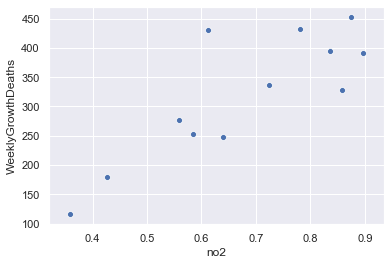

In [65]:
sns.scatterplot(x='no2', y=effect_var[0], data=df_effect_display)

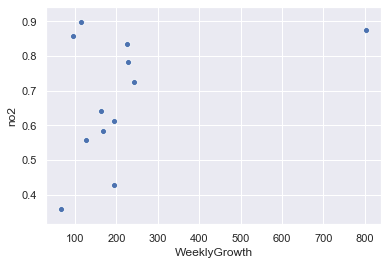

In [66]:
sns.scatterplot(x='WeeklyGrowth', y='no2', data=df_effect_final)

In [67]:
result_ols = smf.ols("WeeklyGrowth ~ no2", data=df_effect_display).fit()

print("n=", len(df_effect_display))

result_ols.summary()

n= 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           WeeklyGrowth   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1.777
Date:                Thu, 23 Apr 2020   Prob (F-statistic):              0.212
Time:                        14:05:51   Log-Likelihood:                -78.628
No. Observations:                  12   AIC:                             161.3
Df Residuals:                      10   BIC:                             162.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -65.6455    219.708     -0.299      0.771    -555.187     423.896
no2          418.2016    313.706      1.333      0.212    -280.778    1117.181
==============================================================================
Omnibus:                       18.730   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.317
Skew:                           1.911   Prob(JB):                     0.000778
Kurtosis:                       6.745   Cond. No.                         8.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
def make_df_effect(df_orig, deaths_start = 20, days_to_assess_response = 7, days_to_assess_result = 21):
    df_response = df_orig[df_orig['TotalDeaths'] >= deaths_start]
    df_response = df_response.sort_values(['Country', 'Date'])

    df_activity_intensity = df_response.groupby('Country').head(days_to_assess_response)

    df_activity_intensity = df_activity_intensity.groupby('Country')[['no2']].mean()
    assess_variables = ['Total', 'TotalDeaths', 'WeeklyGrowth', 'WeeklyGrowthDeaths']

    assess_variables_exp = ['Total', 'TotalDeaths']

    df_situation_start = df_response.groupby('Country').head(1).set_index('Country')[assess_variables]
    
    df_response = df_response.sort_values(['Country', 'Date'])

    df_situation_final = df_response.groupby('Country').head(days_to_assess_result)

    # only keep countries that have results beyond the number of days to assess result
    valid_countries = df_situation_final.groupby('Country').count().iloc[:, 0] == days_to_assess_result

    df_situation_final = df_situation_final.groupby('Country').tail(1).set_index('Country')[assess_variables]

    df_situation_final = df_situation_final[valid_countries]
    
    df_effect = df_situation_final / df_situation_start

    df_effect.columns = [s + '_ratio' for s in df_effect.columns]
    df_effect_join = df_situation_start.join(df_situation_final, rsuffix='2')

    for var in assess_variables_exp:
        df_effect[var + '_rate'] = df_effect_join.apply(lambda x: math.pow((x[var + '2']/x[var]), (1.0/days_to_assess_result)), axis=1)

    df_effect = df_effect.join(df_situation_final)
    
    df_effect_final = df_effect.join(df_activity_intensity)
    return df_effect_final



In [69]:
df_results = pd.DataFrame([], columns=['p', 'var'])

df_results

Empty DataFrame
Columns: [p, var]
Index: []

In [70]:
# After how many deaths to start assessing the response?
deaths_start_0 = 5

# How many days to use, after the start of assessment, to measure the response
days_to_assess_response_0 = 5

# How many days to use, after the start of assessment, to measure the response
days_to_assess_result_0 = 10

df_results = pd.DataFrame([], columns=['p', 'corr', 'var', 'n', 'deaths_start', 'days_to_assess_response', 'days_to_assess_result'])

for deaths_start in range(deaths_start_0, 80):
    for days_to_assess_response in range(days_to_assess_response_0, 14):
        for days_to_assess_result in range (days_to_assess_response, days_to_assess_response + 21):
            df = make_df_effect(df_orig, deaths_start, days_to_assess_response, days_to_assess_result)
            df_corr = df.corr(method='pearson')
            if len(df_corr['no2'].dropna()) < 6: continue
            df_p = df.corr(method=pearsonr_pval)
            p = df_p['no2'].min()
            var = df_p['no2'].idxmin()
            corr = df_corr.loc['no2', var]
            n = len(df[var].dropna())
            df_results = df_results.append(pd.Series([p, corr, var, n, deaths_start, days_to_assess_response, days_to_assess_result], index = df_results.columns), ignore_index=True)

df_results

p      corr                       var   n deaths_start days_to_assess_response days_to_assess_result
0      0.194037 -0.512530        WeeklyGrowthDeaths   8            5                       5                     5
1      0.243892  0.364622                     Total  12            5                       5                     6
2      0.198517  0.951774  WeeklyGrowthDeaths_ratio   3            5                       5                     7
3      0.139058  0.976239  WeeklyGrowthDeaths_ratio   3            5                       5                     8
4      0.170030  0.423571                     Total  12            5                       5                     9
...         ...       ...                       ...  ..          ...                     ...                   ...
14170  0.058250  0.689971        WeeklyGrowthDeaths   8           79                      13                    29
14171  0.035790  0.740071        WeeklyGrowthDeaths   8           79                      13                    30
14172  0.054172  0.698065        WeeklyGrowthDeaths   8           79                      13                    31
14173  0.091363  0.682144        WeeklyGrowthDeaths   7           79                      13                    32
14174  0.156739  0.597293        WeeklyGrowthDeaths   7           79                      13                    33

[14175 rows x 7 columns]

In [71]:
df_results = df_results.sort_values('p')

df_results.head(1000)

p      corr                       var   n deaths_start days_to_assess_response days_to_assess_result
181    0.000100  1.000000  WeeklyGrowthDeaths_ratio   3            5                      13                    26
373    0.000116  0.999884  WeeklyGrowthDeaths_ratio   4            6                      13                    29
411    0.000667  0.837874        WeeklyGrowthDeaths  12            7                       6                    18
431    0.000862  0.828807        WeeklyGrowthDeaths  12            7                       7                    18
176    0.000963  0.999999  WeeklyGrowthDeaths_ratio   3            5                      13                    21
4390   0.001069  0.869863  WeeklyGrowthDeaths_ratio  10           28                       7                     8
368    0.001196  0.998804  WeeklyGrowthDeaths_ratio   4            6                      13                    24
3785   0.001333  0.862145  WeeklyGrowthDeaths_ratio  10           25                       5                    10
4370   0.001393  0.860570  WeeklyGrowthDeaths_ratio  10           28                       6                     8
4350   0.001482  0.858276  WeeklyGrowthDeaths_ratio  10           28                       5                     8
371    0.001538  0.998462  WeeklyGrowthDeaths_ratio   4            6                      13                    27
372    0.001582  0.998418  WeeklyGrowthDeaths_ratio   4            6                      13                    28
370    0.001776  0.998224  WeeklyGrowthDeaths_ratio   4            6                      13                    26
451    0.001970  0.795631        WeeklyGrowthDeaths  12            7                       8                    18
11759  0.002024  0.819419        WeeklyGrowthDeaths  11           67                       6                    26
11738  0.002060  0.818661        WeeklyGrowthDeaths  11           67                       5                    25
391    0.002100  0.792771        WeeklyGrowthDeaths  12            7                       5                    18
5335   0.002297  0.841001  WeeklyGrowthDeaths_ratio  10           33                       7                     8
4957   0.002297  0.841001  WeeklyGrowthDeaths_ratio  10           31                       7                     8
5146   0.002297  0.841001  WeeklyGrowthDeaths_ratio  10           32                       7                     8
11758  0.002468  0.810724        WeeklyGrowthDeaths  11           67                       6                    25
718    0.002486  0.785075        WeeklyGrowthDeaths  12            8                      12                    16
12137  0.002561  0.809054        WeeklyGrowthDeaths  11           69                       6                    26
11948  0.002561  0.809054        WeeklyGrowthDeaths  11           68                       6                    26
3596   0.002573  0.836170  WeeklyGrowthDeaths_ratio  10           24                       5                    10
369    0.002602  0.997398  WeeklyGrowthDeaths_ratio   4            6                      13                    25
471    0.002729  0.780677        WeeklyGrowthDeaths  12            7                       9                    18
4161   0.002736  0.833504  WeeklyGrowthDeaths_ratio  10           27                       5                     8
5126   0.002835  0.831932  WeeklyGrowthDeaths_ratio  10           32                       6                     8
4937   0.002835  0.831932  WeeklyGrowthDeaths_ratio  10           31                       6                     8
5315   0.002835  0.831932  WeeklyGrowthDeaths_ratio  10           33                       6                     8
207    0.002951  0.776910                     Total  12            6                       5                    23
3805   0.002960  0.830005  WeeklyGrowthDeaths_ratio  10           25                       6                    10
12136  0.003019  0.801414        WeeklyGrowthDeaths  11           69                       6            